In [1]:
import json
from pprint import pprint
class AutoSaveDict(dict):
    def __init__(self, json_file):
        self.json_file = json_file
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
                super().__init__(data)
        except FileNotFoundError:
            super().__init__()

    def __setitem__(self, key, value):
        super().__setitem__(key, value)
        self.save_to_json()

    def __delitem__(self, __key) -> None:
        super().__delitem__(__key)
        self.save_to_json()

    def save_to_json(self):
        with open(self.json_file, 'w') as f:
            json.dump(self, f, indent=4)
config = AutoSaveDict("twitter.json")
pprint(config)

{'Log in button': '//a[@href="/login"]',
 'Log in next button': '//div[@role="button"]//span[contains(., \'Next\')]',
 'Log in submit button': '//div[@role="button"][@data-testid="LoginForm_Login_Button"][contains(., '
                         "'Log in')]",
 'OTP': '//input[@data-testid="ocfEnterTextTextInput"]',
 'OTP submit button': '//div[@role="button"][@data-testid="ocfEnterTextNextButton"]',
 'Password field': '//input[@name="password"]',
 'Sign in button': '//a[@href="/login"]',
 'Username field': '//input[@autocomplete="username"]',
 'logInSelector': "//span[text()[contains(., 'Log in')]]",
 'logInSubmitSelector': "//div[@aria-labelledby='modal-header'][@aria-modal='true'][@role='dialog']//div[@role='group'][@tabindex='0']//div[@data-testid='LoginForm_Footer_Container']//div[@data-testid='LoginForm_Login_Button'][@role='button'][@tabindex='0']//div[@dir='ltr']//span//span",
 'loginNextSelector': "//span[text()[contains(., 'Next')]]",
 'passwordSelector': "//input[@type='passwor

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By

driver = webdriver.Edge()

In [3]:
driver.get("https://twitter.com")

In [4]:
driver.set_window_rect(1920,0,1920//2,1000)
print(driver.get_window_rect())

{'height': 1000, 'width': 960, 'x': 1920, 'y': 0}


In [18]:
async def identify(thing: str):
    if thing in config:
        try:
            driver.find_element(By.XPATH, config[thing])
            return config[thing]
        except:
            print("Xpath in config is invalid, reidentifying")
    print("Prompting user to click")
    selector = driver.execute_async_script(
        open("picker.js","r").read(),
        thing
    )
    print(f"Prompt resulted in selector {selector}")
    if selector is not None:
        config[thing] = selector
        assert driver.find_element(By.XPATH, config[thing]) is not None
        return config[thing]
    else:
        return None

In [6]:
async def click(thing):
    xpath = await identify(thing)
    driver.execute_script(f"""
        document.evaluate(
            `{xpath}`, document, null, XPathResult.FIRST_ORDERED_NODE_TYPE, null
        ).singleNodeValue.click();
    """)

In [7]:
async def focus(thing):
    xpath = await identify(thing)
    """
    1. Insert a panel into the page to absorb a mouse click
    2. Click the browser content area to allow for programmatic focusing of elements (browser security thing)
    3. The panel removes itself
    4. The element is focused
    """
    import pyautogui
    driver.execute_script(r"""
const panel = document.createElement("div");
panel.style.position = "fixed";
panel.style.top = "0";
panel.style.left = "0";
panel.style.width = "100%";
panel.style.height = "100%";
panel.style.zIndex = "9999";
panel.style.background = "rgba(0,0.5,0,0.5)";
panel.innerText = "CLICK FOR FOCUS";
panel.style.color = "white";
panel.style.fontSize = "50px";
panel.style.fontFamily = "Impact, Charcoal, sans-serif";

panel.style.display = "flex";
panel.style.justifyContent = "center";
panel.style.alignItems = "center";
panel.style.cursor = "pointer";
document.body.appendChild(panel);
panel.addEventListener("click", () => {
    document.body.removeChild(panel);
});
""")
    # click on the browser window
    restore = pyautogui.position()
    pyautogui.click(driver.get_window_position()['x'] + driver.get_window_size()["width"]//4, driver.get_window_position()['y'] + driver.get_window_size()["height"]//2)
    pyautogui.moveTo(restore)

    driver.execute_script(f"""
        document.evaluate(
            `{xpath}`, document, null, XPathResult.FIRST_ORDERED_NODE_TYPE, null
        ).singleNodeValue.focus();
    """)


In [8]:
await click("Log in button")

In [9]:
await focus("Username field")

Xpath in config is invalid, reidentifying
Prompting user to click
Prompt resulted in selector //input[@autocapitalize="sentences"][@autocomplete="username"]


In [10]:
from typing import List

async def isOnePassOpen():
    import mss
    import pyautogui
    from IPython.display import display
    from PIL import Image
    def getMouseMonitorScreenshot():
        # Get the current mouse position
        mouse_x, mouse_y = pyautogui.position()

        # Determine the monitor the mouse is on
        with mss.mss() as sct:
            target_monitor = None
            for monitor in sct.monitors[1:]:
                if monitor["left"] <= mouse_x < monitor["left"] + monitor["width"] and monitor["top"] <= mouse_y < monitor["top"] + monitor["height"]:
                    target_monitor = monitor
                    break

            if target_monitor:
                image = sct.grab(target_monitor)
                return Image.frombytes("RGB", image.size, image.bgra, "raw", "BGRX")
            else:
                return None
    import pytesseract
    pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
    def recognize_text(image):
        return pytesseract.image_to_string(image, lang="eng")
    
    
    text = recognize_text(getMouseMonitorScreenshot())
    # print("OCR", text)
    if "Search 1Password" in text or "Q earch 1Password" in text:
        return True
    elif "Copy Username" in text and "Copy Password" in text:
        return True
    else:
        return False
async def fillValueFromOnePass(thing: str, search: str, hotkey: List[str]) -> str:
    await identify(thing)
    import pyautogui
    from time import sleep
    # hotkey to open 1Password search
    pyautogui.hotkey("ctrl","shift","space")
    sleep(0.5)
    if isOnePassOpen():
        pyautogui.typewrite(search)
        sleep(0.5)
        pyautogui.hotkey(*hotkey)
        await focus(thing)
        sleep(0.5)
        # select text in input if any
        pyautogui.hotkey("ctrl","a")
        # paste clobbering the text
        pyautogui.hotkey("ctrl","v")

In [11]:
await fillValueFromOnePass("Username field", "twitter", ("ctrl","c"))

C:\Users\TeamD\AppData\Local\Temp\ipykernel_32324\29930543.py:46: RuntimeWarning: coroutine 'isOnePassOpen' was never awaited
  if isOnePassOpen():


In [12]:
await click("Log in next button")

In [13]:
await fillValueFromOnePass("Password field", "twitter", ("ctrl","shift","c"))

Xpath in config is invalid, reidentifying
Prompting user to click
Prompt resulted in selector //input[@name="password"]


C:\Users\TeamD\AppData\Local\Temp\ipykernel_32324\29930543.py:46: RuntimeWarning: coroutine 'isOnePassOpen' was never awaited
  if isOnePassOpen():


In [14]:
thing = "Log in submit button"
# del config[thing]
await click(thing)

In [16]:
await fillValueFromOnePass("OTP", "twitter", ("ctrl","alt","c"))

Xpath in config is invalid, reidentifying
Prompting user to click
Prompt resulted in selector //input[@data-testid="ocfEnterTextTextInput"]


C:\Users\TeamD\AppData\Local\Temp\ipykernel_32324\29930543.py:46: RuntimeWarning: coroutine 'isOnePassOpen' was never awaited
  if isOnePassOpen():


In [17]:
thing = "OTP submit button"
# del config[thing]
await click(thing)

In [19]:
thing = "tweet"
# del config[thing]
xpath = await identify(thing)
print(xpath)

//article[@data-testid='tweet']


In [23]:
tweets = driver.find_elements(By.XPATH, xpath)
screenshots = [x.screenshot_as_png for x in tweets]

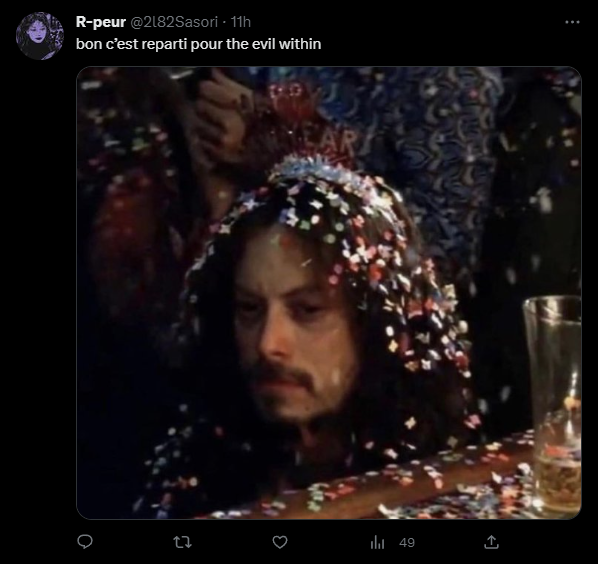

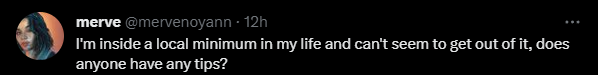

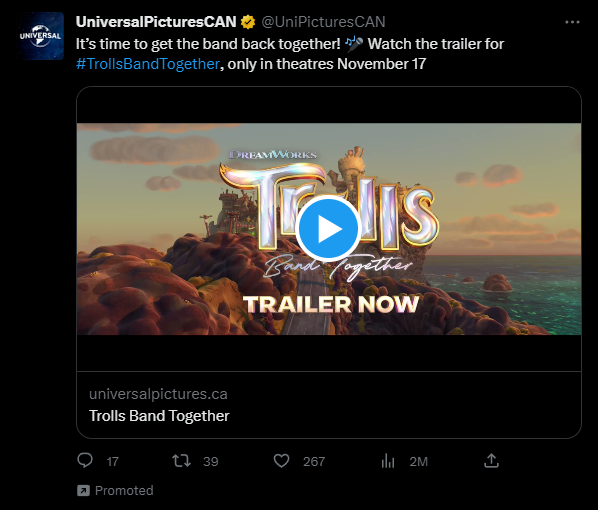

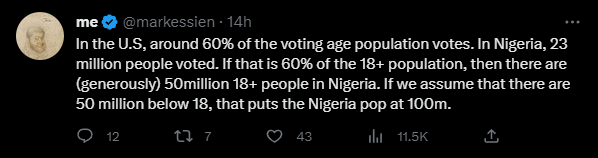

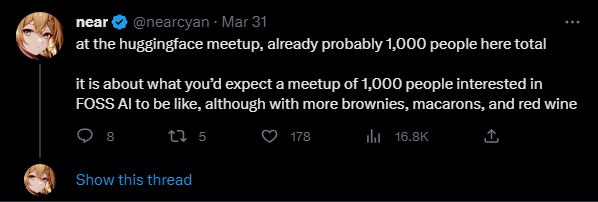

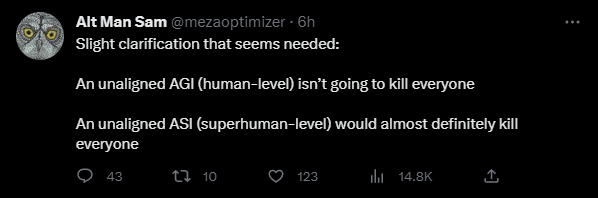

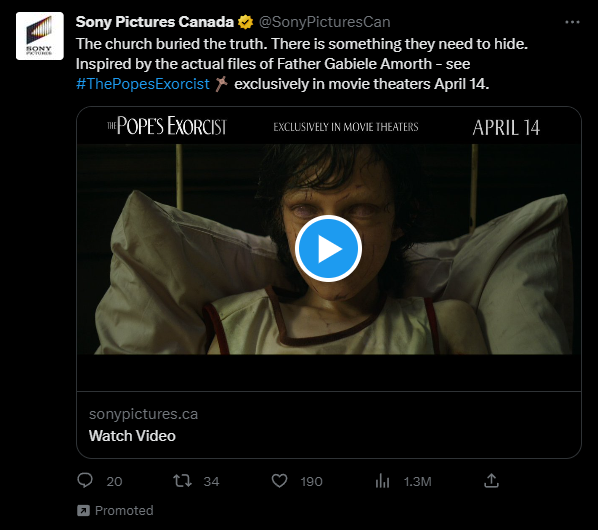

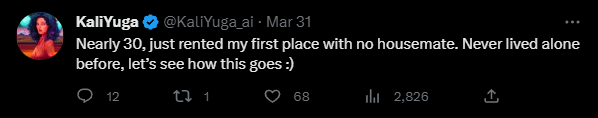

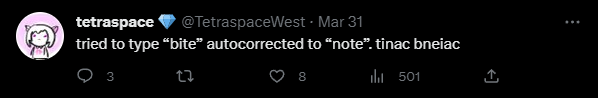

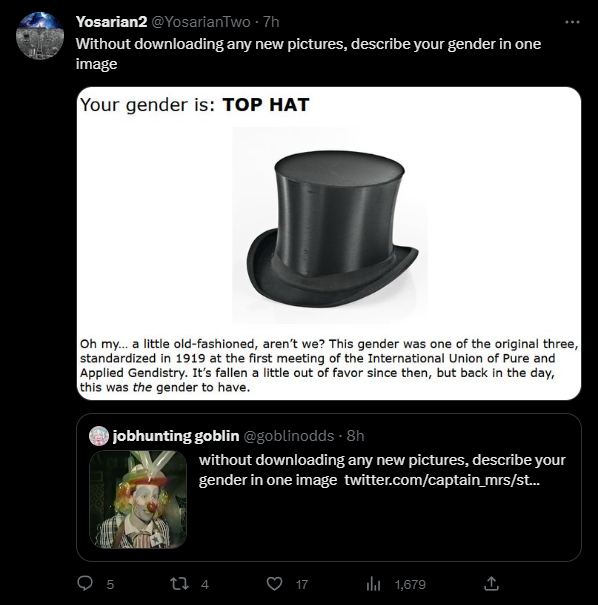

In [24]:
from IPython.display import display, Image
for x in screenshots:
    display(Image(x))